In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from scipy.interpolate import interp1d, splrep, splev
from scipy.optimize import curve_fit
from pycbc import psd as psd_func
from simple_pe.waveforms import make_waveform, calc_f_gen, shifted_e

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

NOTE: this notebook has modified make_waveform() to return complex harmonics before orthogonalisation - may not work if this is not done.

# Plotting harmonics

In [248]:
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

params = {'ecc10sqrd': 0.3**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0, 'distance': 1}
hs = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)

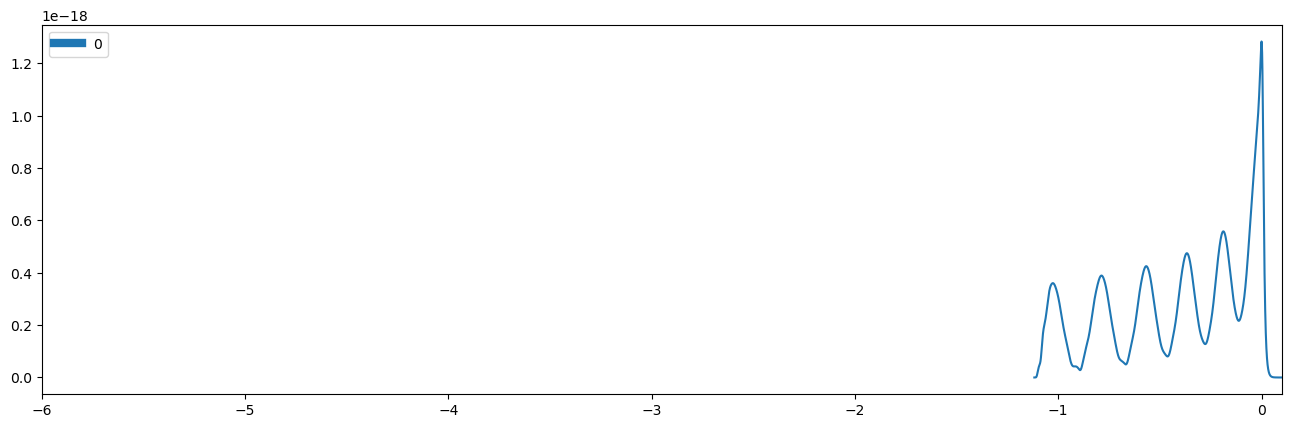

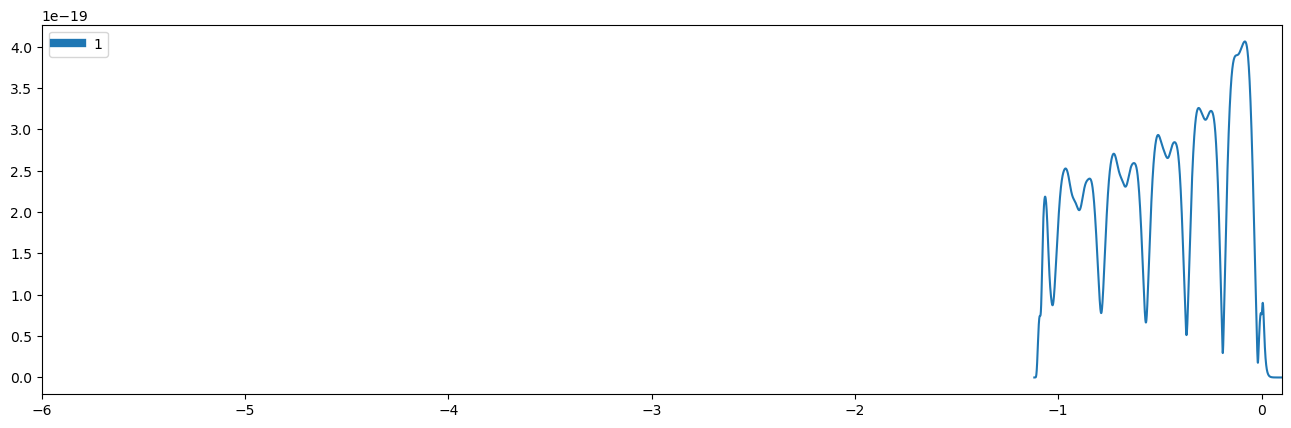

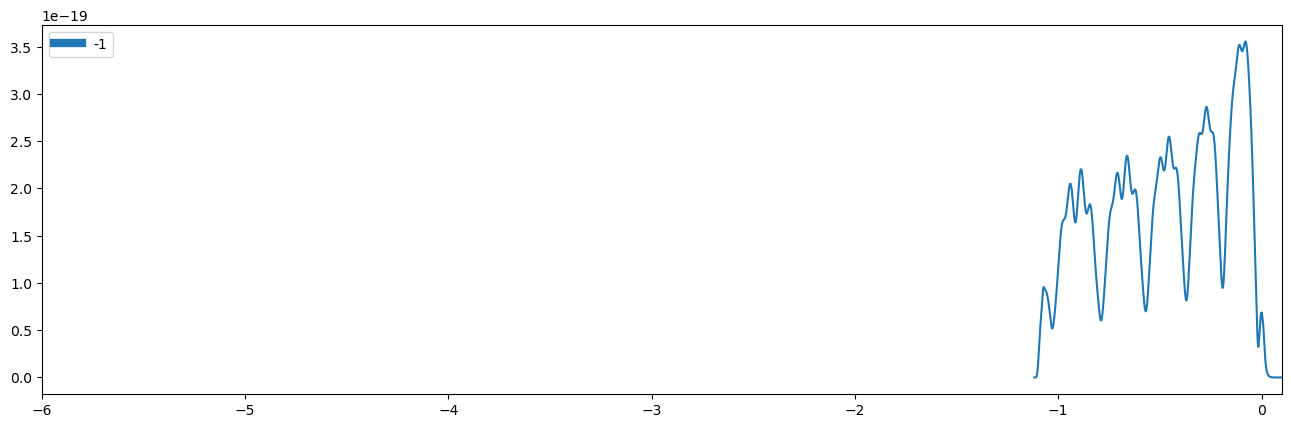

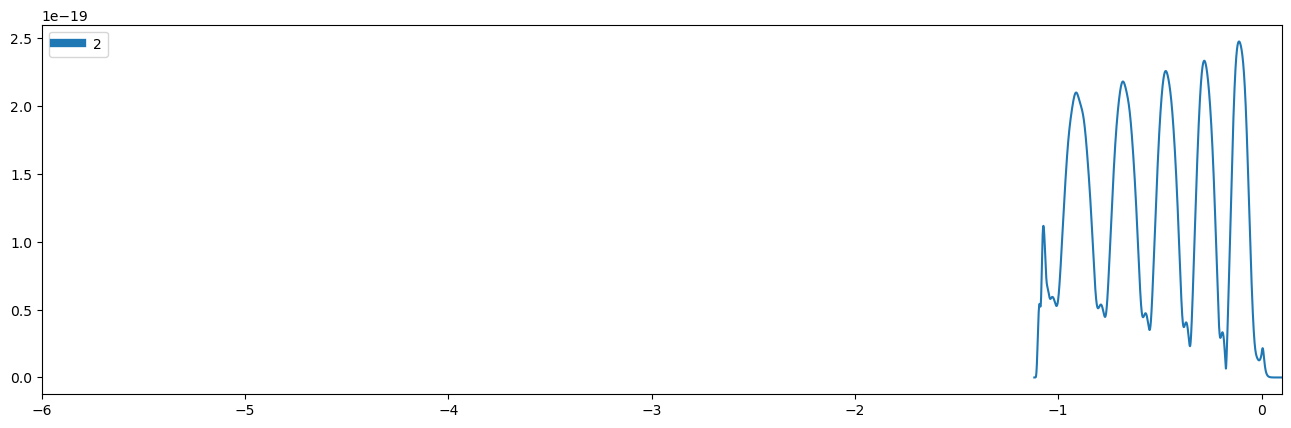

In [235]:
for key in hs.keys():
    plt.figure(figsize=(6.4*2.5, 4.8))
    plt.plot(hs[key].sample_times, np.abs(hs[key]), label=str(key))
    plt.legend()
    plt.xlim(-6, 0.1)
    plt.show()

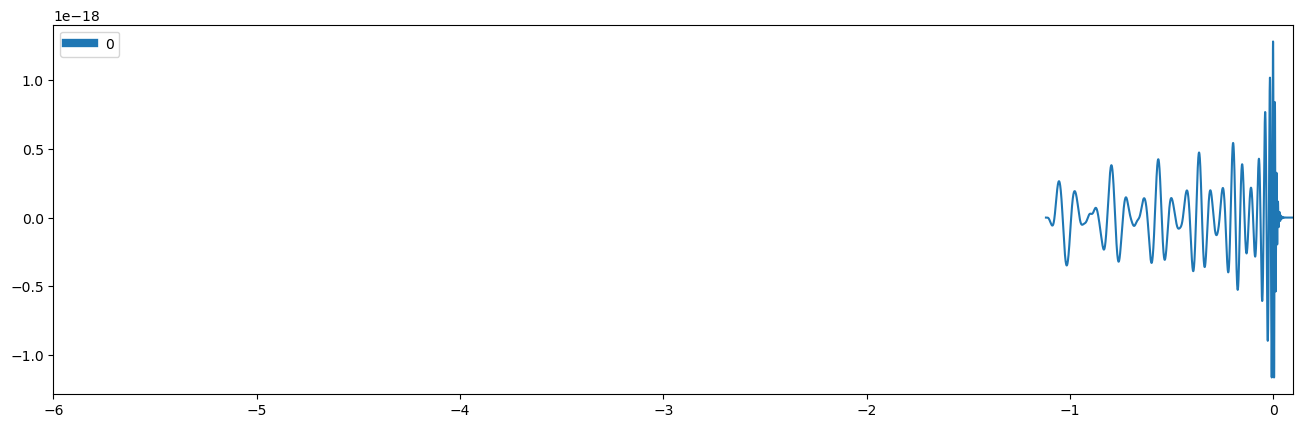

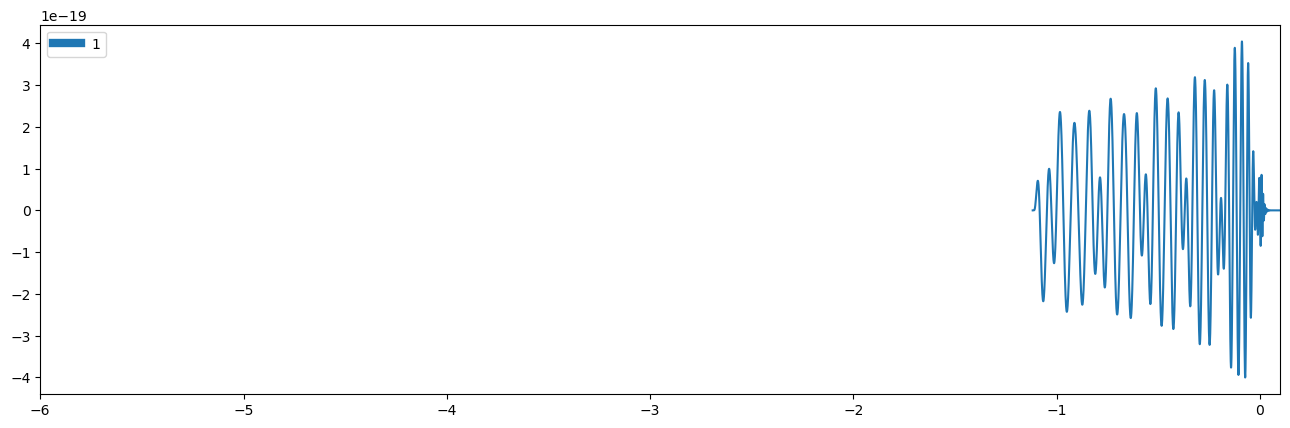

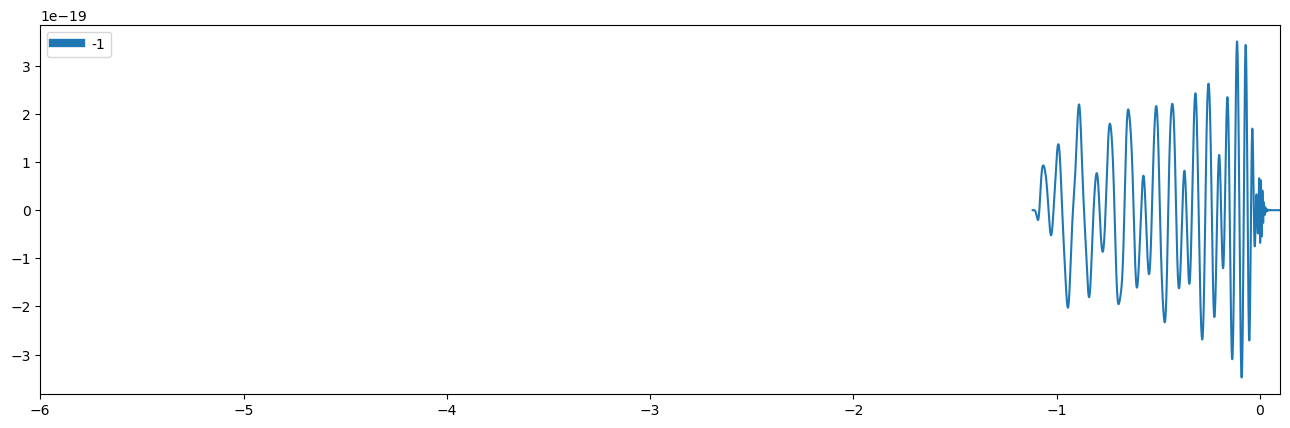

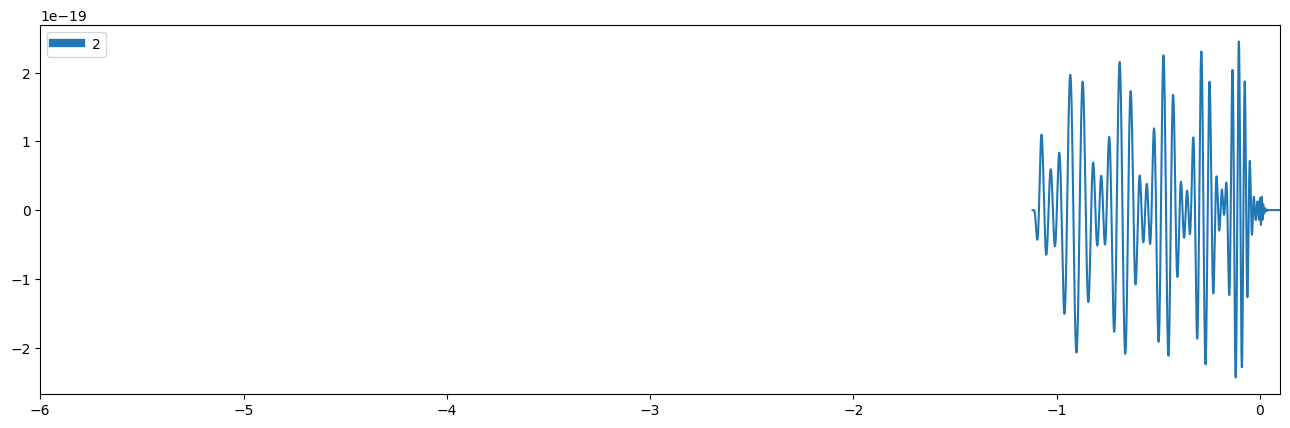

In [236]:
for key in hs.keys():
    plt.figure(figsize=(6.4*2.5, 4.8))
    plt.plot(hs[key].sample_times, hs[key], label=str(key))
    plt.legend()
    plt.xlim(-6, 0.1)
    plt.show()

# Smoothing phase

## Dominant

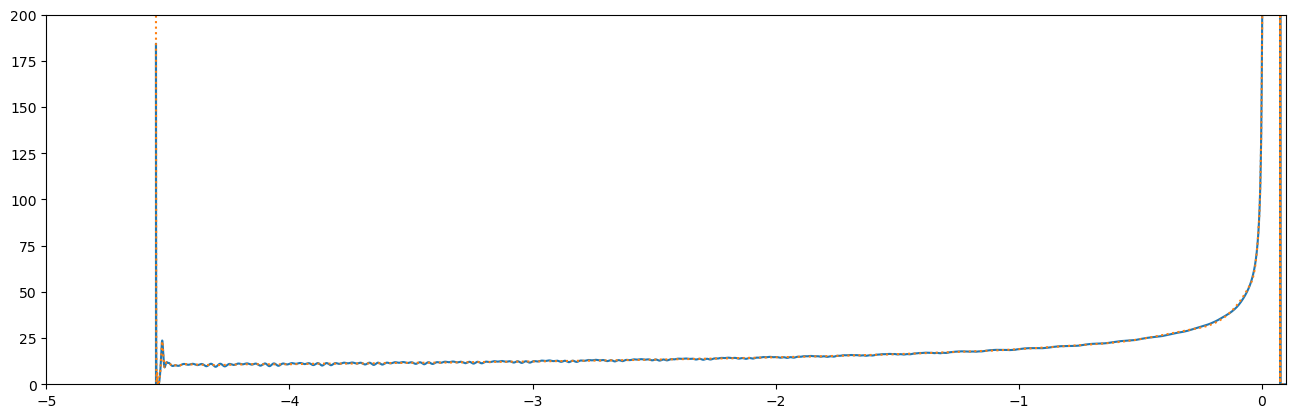

In [305]:
plt.figure(figsize=(6.4*2.5, 4.8))

ang_diffs = (-np.diff(np.angle(hs[0]))-np.pi)%(2*np.pi)-np.pi
f_inst = ang_diffs*sample_rate/(2*np.pi)
plt.plot(hs[0].sample_times[1:], f_inst)

M = params['chirp_mass']*params['symmetric_mass_ratio']**(-3/5)
f_ISCO = const.c**3/(6*np.sqrt(6)*const.G*M[0]*aconst.M_sun.value)
f_gen = calc_f_gen(f_low, 4)
std_mult = np.ones(len(hs[0].sample_times[1:]))
std_mult = (1/(f_ISCO-f_gen)**2)*(f_ISCO-f_inst)**2

f_high_ind = np.where(np.logical_and(hs[0].sample_times[1:]>0, f_inst>f_ISCO))[0][0]
std_mult[f_high_ind:] = 1e-10
std = np.std(f_inst[int(0.5*(1/f_gen)*sample_rate):int(2.5*(1/f_gen)*sample_rate)])
angs_std = std*std_mult*2*np.pi/sample_rate
angs_tck = splrep(hs[0].sample_times[1:], ang_diffs, w=1/angs_std)
smooth_angs = splev(hs[0].sample_times[1:], angs_tck)
new_phases = [np.angle(hs[0][0])]+list(np.angle(hs[0][0])-np.cumsum(smooth_angs))
new_h0 = hs[0]*np.exp(1j*(new_phases-np.angle(hs[0])))
new_ang_diffs = (-np.diff(np.angle(new_h0))-np.pi)%(2*np.pi)-np.pi
new_f_inst = new_ang_diffs*sample_rate/(2*np.pi)
plt.plot(new_h.sample_times[1:], new_f_inst, ls='dotted')

plt.xlim(-5, 0.1)
plt.ylim(0, 200)
plt.show()

## Sub-dominant

In [289]:
# Gets orbital frequency from gravitational wave frequency
def calc_f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def calc_f_ap(f_gw, f_ref, ecc, M):
    P_orb = 1/calc_f_orb(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    M_SI = M*aconst.M_sun.value
    numerator = 6*np.pi*const.G*M_SI
    a = ((const.G*M_SI*P_orb**2)/(4*np.pi**2))**(1/3)
    denominator = const.c**2*a*(1-e**2)
    peri_advance_per_orb = numerator/denominator
    P_ap = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_orb - 1/P_ap

In [290]:
f_ap

array([-4.95040270e+62, -3.31728519e+62, -1.94333519e+62, ...,
       -2.85246583e+60, -2.85246583e+60, -2.85246583e+60])

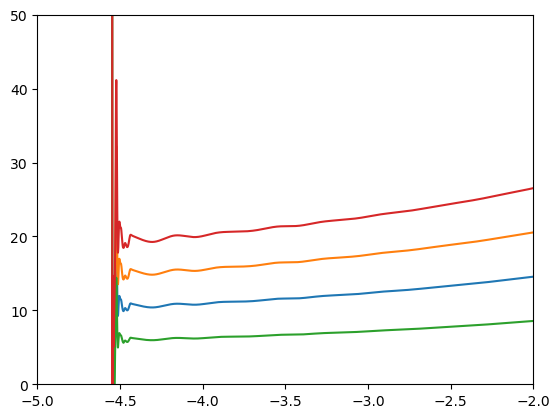

In [303]:
for key in hs.keys():
    plt.plot(hs[0].sample_times[1:], 2*f_orb+key*f_ap)
plt.xlim(-5, -2)
plt.ylim(0, 50)
plt.show()

In [298]:
f_ap[1000]

7.612981162920701

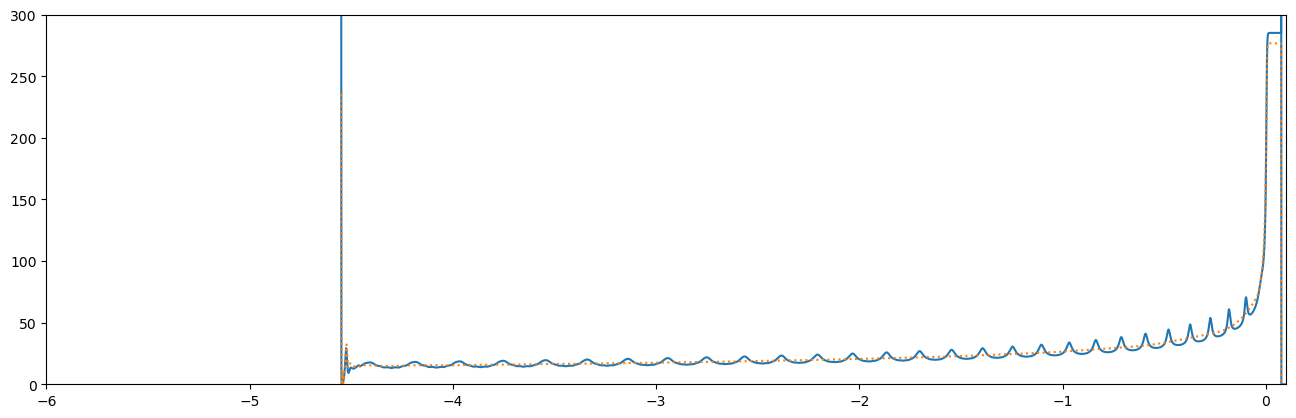

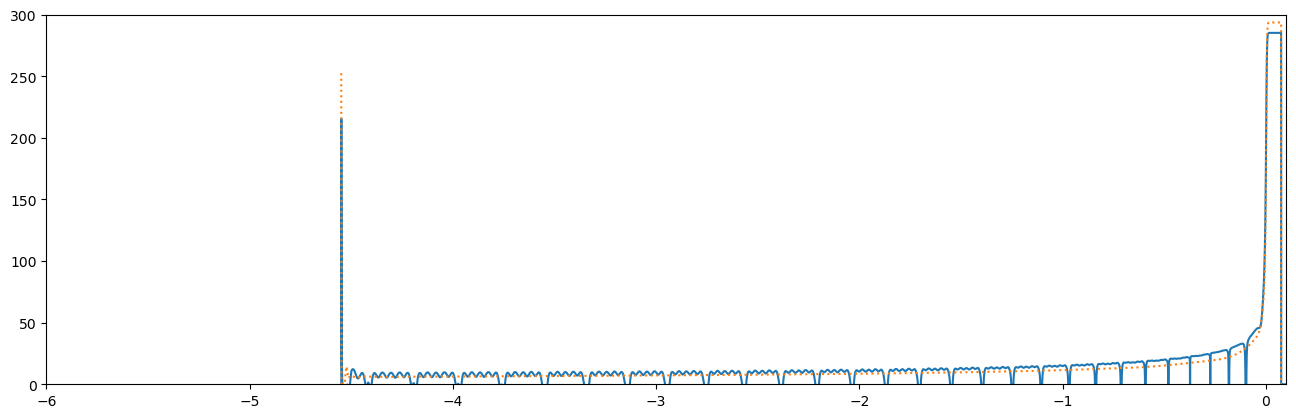

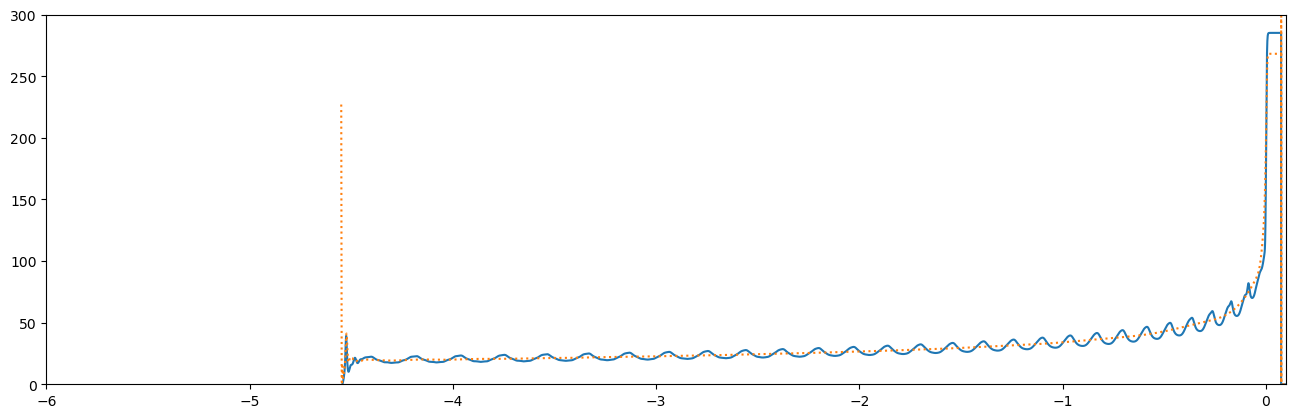

In [306]:
# Calculate both frequencies
f_orb = calc_f_orb(new_f_inst)
f_grid = np.geomspace(f_gen, f_ISCO, 501) # Only needs to be calculated once, used for all psds
f_ap_grid = calc_f_ap(f_grid, 10, params['ecc10sqrd']**0.5, M)
f_ap_interp = interp1d(f_grid, f_ap_grid)
new_f_inst[new_f_inst>f_ISCO] = f_ISCO
new_f_inst[new_f_inst<f_gen] = f_gen
f_ap = f_ap_interp(new_f_inst)

new_hs = {0: new_h0}
for key in hs.keys():
    if key == 0:
        continue

    # Plot original
    plt.figure(figsize=(6.4*2.5, 4.8))
    ang_diffs = (-np.diff(np.angle(hs[key]))-np.pi)%(2*np.pi)-np.pi
    f_inst = ang_diffs*sample_rate/(2*np.pi)
    plt.plot(hs[key].sample_times[1:], f_inst)

    # Plot new
    f_harm = 2*f_orb + key*f_ap
    ang_harm = f_harm*2*np.pi/sample_rate
    new_phases = [np.angle(hs[key][0])]+list(np.angle(hs[key][0])-np.cumsum(ang_harm))
    new_h = hs[key]*np.exp(1j*(new_phases-np.angle(hs[key])))
    new_ang_diffs = (-np.diff(np.angle(new_h))-np.pi)%(2*np.pi)-np.pi
    harm_f_inst = new_ang_diffs*sample_rate/(2*np.pi)
    plt.plot(new_h.sample_times[1:], harm_f_inst, ls='dotted')
    new_hs[key] = new_h

    plt.xlim(-6, 0.1)
    plt.ylim(0, 300)
    plt.show()

# Frequency and eccentricity as function of time

Calculate gw frequency from h0 harmonic (after amp/phase smoothing).

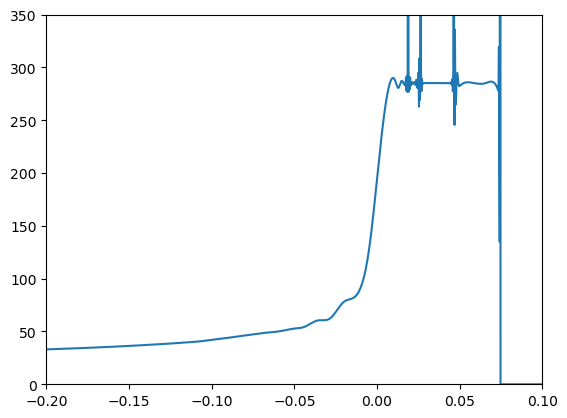

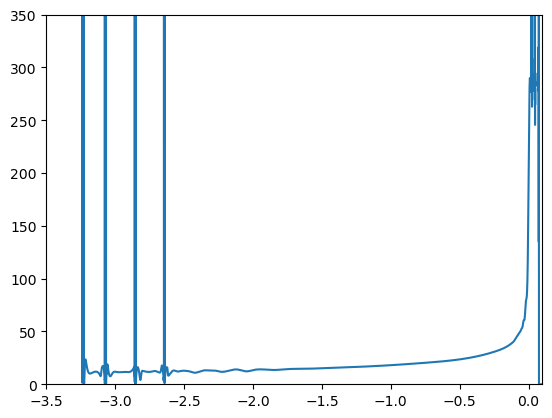

In [8]:
ang_diff = -np.diff(np.angle(hs[0]))
ang_diff = ang_diff % (2*np.pi)
f_inst = ang_diff*sample_rate/(2*np.pi)
plt.plot(hs[0].sample_times[:-1], f_inst)
plt.xlim(-0.2, 0.1)
plt.ylim(0, 350)
plt.show()

plt.plot(hs[0].sample_times[:-1], f_inst)
plt.xlim(-3.5, 0.1)
plt.ylim(0, 350)
plt.show()

The start has some weirdness (likely due to the tapering we have applied to waveforms up to this point). We can get round this by continuing the frequency in a linear fashion to the start time. This part is not too important as should not be included in any match/match filters anyway (and we will re-taper anyway!).

131072
131072


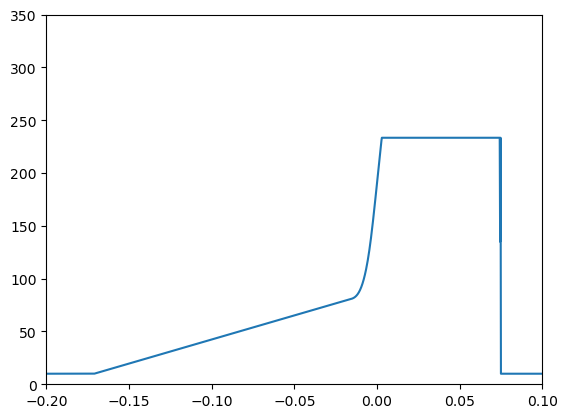

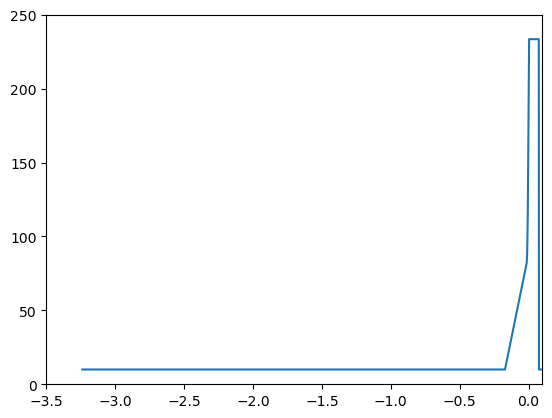

In [13]:
# Extrapolate frequencies of initial linear section
neg_dd_f = np.where(np.diff(np.diff(f_inst))<=0)[0]
end_index = neg_dd_f[np.where(hs[0].sample_times[3:][neg_dd_f]<0)[0]][-1]+3
linear_df = np.diff(f_inst)[end_index]
linear_fs = f_inst[end_index] - np.arange(end_index+1, 0, -1)*linear_df
h0_fs = np.concatenate((linear_fs, f_inst[end_index:]))
print(len(h0_fs))
print(len(hs[0].sample_times))

# Make nicely behaved
f_gen = calc_f_gen(f_low, 4)
h0_fs[h0_fs<f_gen] = f_gen
h0_ts = hs[0].sample_times[h0_fs>0][:-100]
h0_fs = h0_fs[h0_fs>0][:-100]
M = params['chirp_mass']*params['symmetric_mass_ratio']**(-3/5)
f_ISCO = const.c**3/(6*np.sqrt(6)*const.G*M[0]*aconst.M_sun.value)
h0_fs[h0_fs>f_ISCO] = f_ISCO

plt.plot(h0_ts, h0_fs)
plt.xlim(-0.2, 0.1)
plt.ylim(0, 350)
plt.show()

plt.plot(h0_ts, h0_fs)
plt.xlim(-3.5, 0.1)
plt.ylim(0, 250)
plt.show()

We do not need to worry about frequencies at the end as either frequencies are so high that the eccentricity is very close to zero anyway, or the waveform is finished (and we will stop this smoothing after a certain point in h0 ringdown amplitude). We have cut the frequencies (and corresponding time array) to before the frequencies go to zero, and set any frequencies above f_ISCO to f_ISCO for simplicity.

For now let's just use the current equation we have to relate eccentricity and frequency.

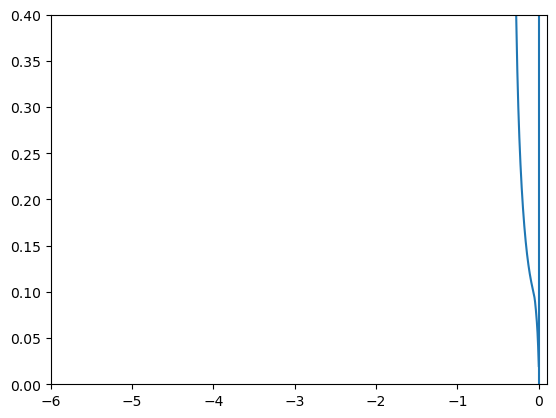

In [208]:
f_grid = np.geomspace(f_gen, f_ISCO, 501) # Only needs to be calculated once, used for all psds
e_grid = shifted_e(f_grid, 10, params['ecc10sqrd']**0.5)
fe_interp = interp1d(f_grid, e_grid)
h0_es = fe_interp(h0_fs)
keep_inds = np.where(np.diff(h0_es)<0)[0]
h0_es = h0_es[keep_inds]
h0_ts = h0_ts[keep_inds]

plt.plot(h0_ts, h0_es)
plt.axvline(0)
plt.xlim(-6, 0.1)
plt.ylim(0, 0.4)
plt.show()

Cut here where eccentricity stops decreasing. For amplitudes after this can multiply by same factor as last point to ensure continuity and (rough) smoothness.

# Fit smoothing function

Now we want to fit the model $A e^n$ to each subdominant harmonic.

In [204]:
def harm_e_fit(e, A, n):
    return A*e**n

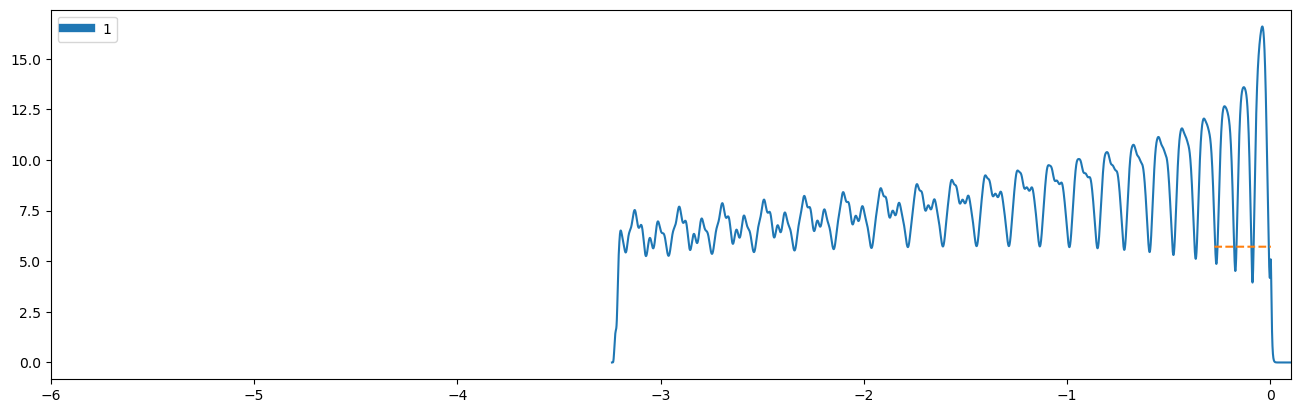

[5.71951467e+00 5.02476591e-21] [[2.12361583e-42 3.03317007e-32]
 [3.03317007e-32 4.38975493e-22]]


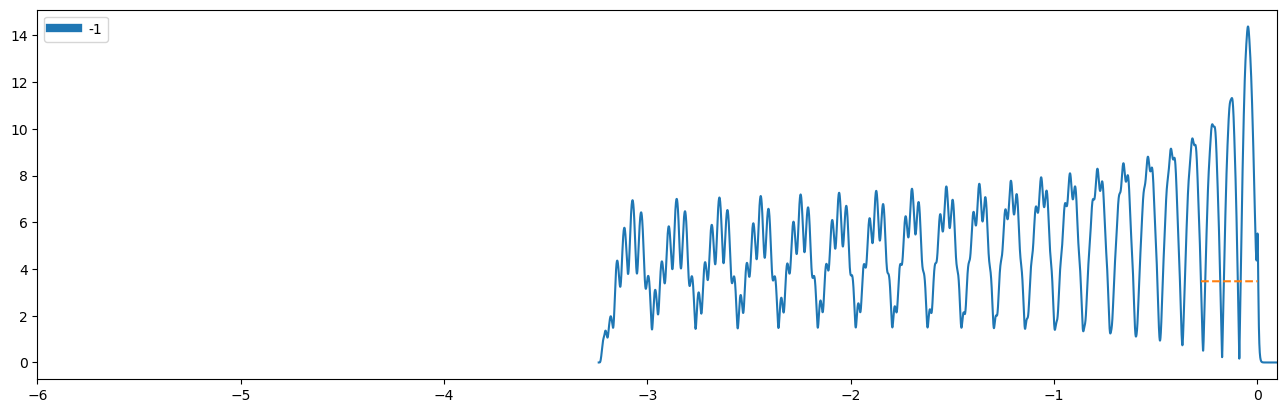

[3.47509238e+00 1.02237689e-13] [[2.12361583e-42 3.03317007e-32]
 [3.03317007e-32 4.38975493e-22]]


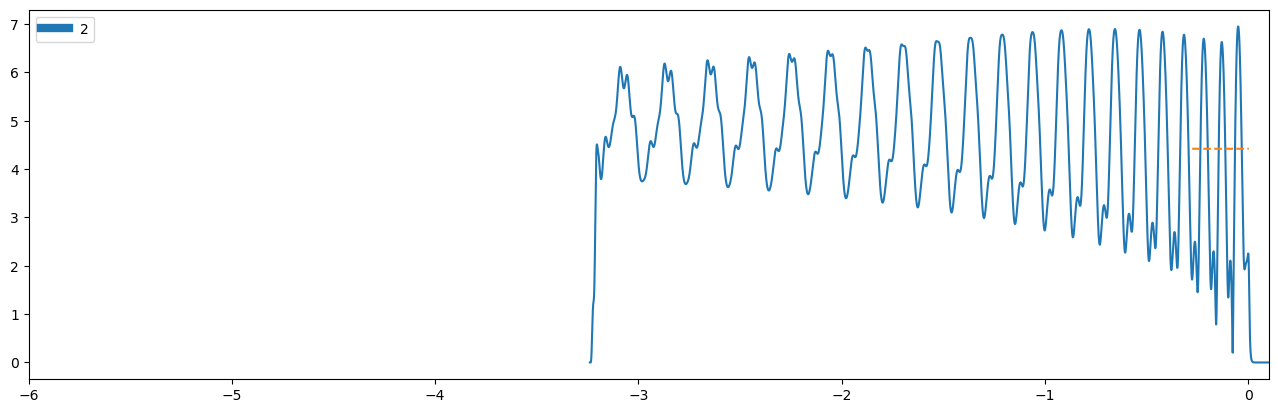

[4.42151257e+00 8.07256968e-20] [[2.12361583e-42 3.03317007e-32]
 [3.03317007e-32 4.38975493e-22]]


In [205]:
for key in hs.keys():
    if key == 0:
        continue

    popt, _ = curve_fit(harm_e_fit, h0_es, 1e20*np.abs(hs[key][:len(h0_ts)]), bounds=[(0, 0), (10, 2)])
    plt.figure(figsize=(6.4*2.5, 4.8))
    plt.plot(hs[key].sample_times, 1e20*np.abs(hs[key]), label=str(key))
    plt.plot(h0_ts, harm_e_fit(h0_es, *popt), c='C1', ls='dashed')
    plt.legend()
    plt.xlim(-6, 0.1)
    plt.show()
    print(popt, pcov)

We find that for these signals the tendency is mostly for the eccentric harmonics to actually increase slightly towards merger, meaning that the power on the eccentricity is pushed towards the lower bound of 0, and the smoothed amplitude does not tend to zero at merger as we would like. If we had a much longer inspiral, I suspect this would not be a problem but this would obviously be very expensive.

Plan to try this regardless and see how it works!

# Average eccentricity

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc import psd as psd_func
from pycbc.filter import sigmasq
from simple_pe.waveforms import make_waveform

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

\begin{equation}
f_{\mathrm{ISCO}} = \frac{1}{6\sqrt{6}\pi}\frac{c^3}{Gm}
\end{equation}

In [5]:
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

chirps = np.linspace(5, 100, 41)
avg_eccs = []
for chirp in chirps:

    # Make waveform
    params = {'ecc10sqrd': 0.2**2, 'chirp_mass': chirp, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0, 'distance': 1}
    hp = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali')
    
    # Calculate integrals
    M = chirp*params['symmetric_mass_ratio']**(-3/5)
    f_ISCO = const.c**3/(6*np.sqrt(6)*const.G*M*aconst.M_sun.value)
    denom_int = sigmasq(hp, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=f_ISCO)
    eccs = params['ecc10sqrd']**0.5*(10/hp.sample_frequencies)**(19/18)
    num_int = sigmasq(hp*np.sqrt(eccs), psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=f_ISCO)
    avg_ecc = num_int/denom_int
    avg_eccs.append(avg_ecc)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 
Initial frequency too high. Set f0 to 1.92e-02 


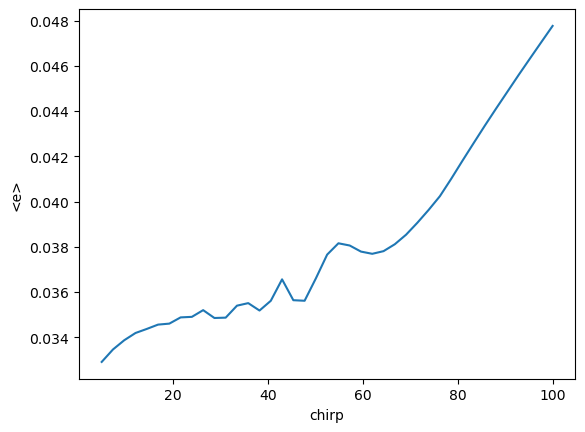

In [6]:
plt.plot(chirps, avg_eccs)
plt.xlabel('chirp')
plt.ylabel('<e>')
plt.show()